# Comparison of parameter inference results

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn
from dynamo.tools.dynamics import kinetic_model
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [2]:
# load data
filename = './data/rpe1.h5ad'
rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

rpe1_kinetics_without_spliced = rpe1_kinetics.copy()

rpe1_kinetics_without_spliced.layers['new'], rpe1_kinetics_without_spliced.layers['total'] = rpe1_kinetics_without_spliced.layers['ul'] + rpe1_kinetics_without_spliced.layers['sl'], \
                                                             rpe1_kinetics_without_spliced.layers['su'] + rpe1_kinetics_without_spliced.layers['sl'] + \
                                                             rpe1_kinetics_without_spliced.layers['uu'] + rpe1_kinetics_without_spliced.layers['ul']

del rpe1_kinetics_without_spliced.layers['uu'], rpe1_kinetics_without_spliced.layers['ul'], rpe1_kinetics_without_spliced.layers['su'], rpe1_kinetics_without_spliced.layers['sl']

del rpe1

##  Inferred results without spliced mRNA information

In [3]:
# preprocessing
dyn.preprocessing.recipe_monocle(
    rpe1_kinetics_without_spliced,
    tkey='time',
    experiment_type="kin",
    reset_X=True,
    X_total_layers=False,
    splicing_total_layers=False,
    n_top_genes=1000,
    total_layers=True,
    keep_filtered_cells=False,
    keep_filtered_genes=True,
    keep_raw_layers=True,
)
dyn.tl.moments(rpe1_kinetics_without_spliced, group='time')
sub_adata_without_spliced = rpe1_kinetics_without_spliced[:,rpe1_kinetics_without_spliced.var['use_for_pca']]
del rpe1_kinetics_without_spliced

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache ]
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
35 input query terms found no hit:
	['ENS

In [4]:
# obtain parameters inference results and goodness-of-fit for different methods

# Dynamo twostep method
results_dynamo = kinetic_model(
    sub_adata_without_spliced,
    est_method="twostep",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_dynamo[0]
Dynamo_gamma = params['gamma']
Dynamo_gamma_r2 = params['gamma_r2']


# CSP method
results_csp = kinetic_model(
    sub_adata_without_spliced,
    est_method="CSP4ML_CSP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_csp[0]
CSP_gamma = params['gamma']
CSP_gamma_r2 = params['gamma_r2_raw']


# CSZIP method
results_cszip = kinetic_model(
    sub_adata_without_spliced,
    est_method="CSP4ML_CSZIP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_cszip[0]
CSZIP_gamma = params['gamma']
CSZIP_gamma_r2 = params['gamma_r2_raw']

|-----> experiment type: kin, method: twostep, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 604.63it/s]

|-----> experiment type: kin, method: CSP4ML_CSP, model: deterministic



Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 622.70it/s]
Infer parameters via Maximum Likelihood Estimation: 102it [00:00, 502.52it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 644it [00:01, 444.61it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 820it [00:01, 529.36it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 1000it [00:02, 497.25it/s]


|-----> experiment type: kin, method: CSP4ML_CSZIP, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 586.40it/s]
Infer parameters via Maximum Likelihood Estimation: 33it [00:00, 136.17it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 365it [00:02, 150.32it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 609it [00:04, 152.73it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 763it [00:05, 141.22it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 810it [00:05, 146.40it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 840it [00:05, 136.53it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 1000it [00:07, 140.66it/s]


##  Inferred results with spliced mRNA information

In [5]:
# preprocessing
dyn.preprocessing.recipe_monocle(
    rpe1_kinetics,
    tkey='time',
    experiment_type="kin",
    reset_X=True,
    X_total_layers=False,
    splicing_total_layers=False,
    n_top_genes=1000,
    total_layers=True,
    keep_filtered_cells=False,
    keep_filtered_genes=True,
    keep_raw_layers=True,
)
layers = ["X_new", "X_total", "X_uu", "X_ul", "X_su", "X_sl"] + ["new", "total", "uu", "ul", "su", "sl"]
dyn.tl.moments(rpe1_kinetics, group='time', layers=layers)

# then we want to calculate moments for spliced and unspliced layers based on connectivity graph from spliced
# data.
# first get X_spliced based pca embedding
CM = np.log1p(rpe1_kinetics[:, rpe1_kinetics.var.use_for_pca].layers["X_spliced"].A)
cm_genesums = CM.sum(axis=0)
valid_ind = np.logical_and(np.isfinite(cm_genesums), cm_genesums != 0)
valid_ind = np.array(valid_ind).flatten()

dyn.preprocessing.utils.pca(rpe1_kinetics, CM[:, valid_ind], pca_key="X_spliced_pca")
# then get neighbors graph based on X_spliced_pca
dyn.tl.connectivity.neighbors(rpe1_kinetics, X_data=rpe1_kinetics.obsm["X_spliced_pca"], layer="X_spliced")
# then normalize neighbors graph so that each row sums up to be 1
conn = dyn.tl.connectivity.normalize_knn_graph(rpe1_kinetics.obsp["connectivities"] > 0)
# then calculate moments for spliced related layers using spliced based connectivity graph
dyn.tl.moments(rpe1_kinetics, conn=conn, layers=["X_spliced", "X_unspliced"])
# then perform kinetic estimations with properly preprocessed layers for either the labeling or the splicing
# data

sub_adata = rpe1_kinetics[:,rpe1_kinetics.var['use_for_pca']]
del rpe1_kinetics

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache ]
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
35 input query terms found no hit:
	['ENS

In [6]:
# obtain parameters inference results and goodness-of-fit for different methods

# Dynamo twostep method
results_dynamo = kinetic_model(
    sub_adata,
    est_method="twostep",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=True,
    splicing_labeling=True,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_dynamo[0]
Dynamo_beta = params['beta']


# ICSP method
results_icsp = kinetic_model(
    sub_adata,
    est_method="CSP4ML_ICSP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=True,
    splicing_labeling=True,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_icsp[0]
ICSP_cell_wise_beta = params['beta'].A
ICSP_beta = np.mean(ICSP_cell_wise_beta,axis=1)
ICSP_gamma_s = params['gamma'] # gamma_s
ICSP_gamma = params['gamma_t'] # gamma_t
ICSP_gamma_r2 = params['gamma_r2_raw']

|-----> experiment type: kin, method: twostep, model: deterministic


Estimate slope k via linear regression.: 1000it [00:01, 710.52it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 632.63it/s]


|-----> experiment type: kin, method: CSP4ML_ICSP, model: deterministic


Estimate slope k via linear regression.: 1000it [00:01, 761.80it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 642.02it/s]
Estimate gamma via Maximum Likelihood Estimation: 1000it [00:04, 221.07it/s]
Estimate cell specific alpha and beta: 1000it [08:01,  2.08it/s]


## Plot the comparison of our parameter inference results

In [7]:
CSP_gamma_r2[np.isnan(CSP_gamma_r2)] = 0
CSZIP_gamma_r2[np.isnan(CSZIP_gamma_r2)] = 0
ICSP_gamma_r2[np.isnan(ICSP_gamma_r2)] = 0
Dynamo_gamma_r2[np.isnan(Dynamo_gamma_r2)] = 0

overlap_number = 400 # the number of well-fitted genes selected by each method

# ranking the goodness of fit of different methods
index_CSP = np.argsort(-CSP_gamma_r2)
index_CSZIP = np.argsort(-CSZIP_gamma_r2)
index_ICSP = np.argsort(-ICSP_gamma_r2)
index_Dynamo = np.argsort(-Dynamo_gamma_r2)

# obtaining indicators of overlapping genes that fit well by different methods
index_CSP_CSZIP = np.intersect1d(index_CSP[range(overlap_number)], index_CSZIP[range(overlap_number)])
index_CSP_ICSP = np.intersect1d(index_CSP[range(overlap_number)], index_ICSP[range(overlap_number)])
index_CSP_Dynamo = np.intersect1d(index_CSP[range(overlap_number)], index_Dynamo[range(overlap_number)])
index_ICSP_Dynamo = np.intersect1d(index_ICSP[range(overlap_number)], index_Dynamo[range(overlap_number)])
index_ICSP_ICSP = np.intersect1d(index_ICSP[range(overlap_number)], index_ICSP[range(overlap_number)])

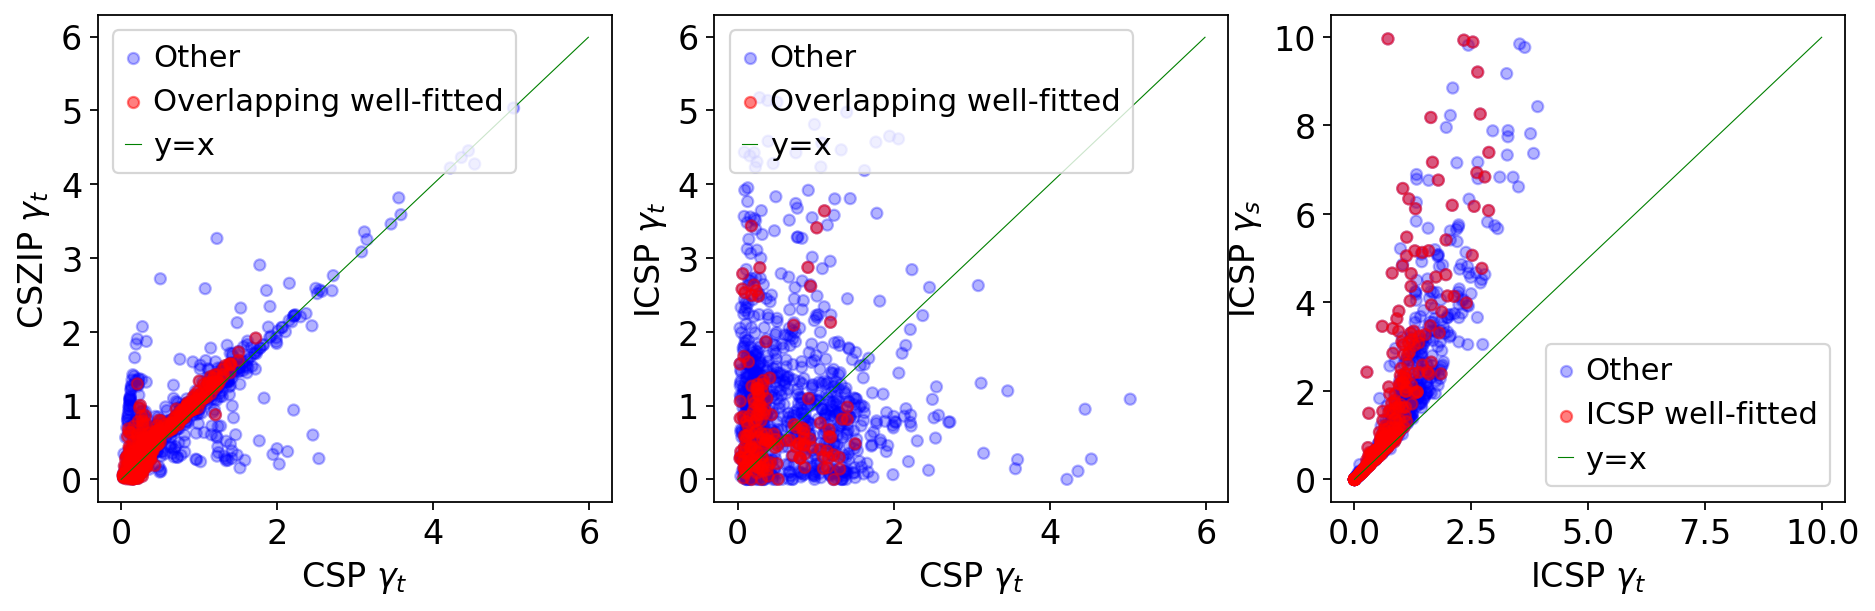

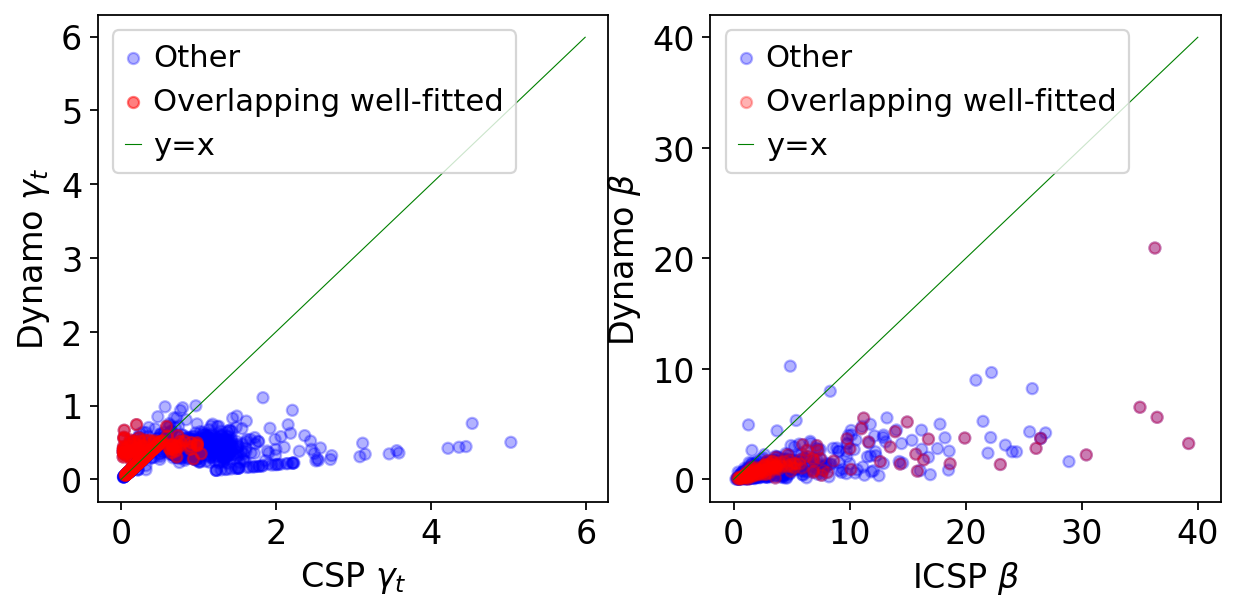

In [8]:
# parameter settings for plotting figures
sc.set_figure_params(scanpy=True, fontsize=15)
scatter_size = 25
figsize1 = (4*3+2, 4)
figsize2 = (4*2+1, 4)
alpha = 0.3


# for y=x line
range_min = 0
range_max = 6
x = np.arange(range_min, range_max, 0.01)
y = x


# comparison of the gamma_t of CSP and CSZIP
fig = plt.figure(1, figsize=figsize1)
ax = fig.add_subplot(1,3,1)
ax.scatter(CSP_gamma, CSZIP_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_CSZIP], CSZIP_gamma[index_CSP_CSZIP], color='red',
           s=scatter_size * np.ones_like(index_CSP_CSZIP), alpha=0.5, label='Overlapping well-fitted')
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.legend()
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('CSZIP $\gamma_{t}$')
plt.grid(False)
# plt.savefig('./comp_figures/1.pdf', dpi=300, bbox_inches="tight")


# comparison of the gamma_t of CSP and ICSP
ax = fig.add_subplot(1,3,2)
ax.scatter(CSP_gamma, ICSP_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_ICSP], ICSP_gamma[index_CSP_ICSP], color='red',
           s=scatter_size * np.ones_like(index_CSP_ICSP), alpha=0.5, label='Overlapping well-fitted')
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.legend()
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('ICSP $\gamma_{t}$')
plt.grid(False)
# plt.savefig('./comp_figures/2.pdf', dpi=300, bbox_inches="tight")


# comparison of gamma_t and gamma_s of ICSP
index_ICSP_leq10 = np.where(ICSP_gamma_s < 10) # only genes with gamma_s less than 10 are shown
index_ICSP_ICSP_leq10 = np.intersect1d(index_ICSP_ICSP, index_ICSP_leq10)
x_ICSP = np.arange(0, 10, 0.01)
y_ICSP = x_ICSP
# fig = plt.figure(3, figsize=figsize)
ax = fig.add_subplot(1,3,3)
ax.scatter(ICSP_gamma[index_ICSP_leq10], ICSP_gamma_s[index_ICSP_leq10], color='blue',
           s=scatter_size * np.ones_like(index_ICSP_leq10), alpha=alpha,
           label='Other')
ax.scatter(ICSP_gamma[index_ICSP_ICSP_leq10], ICSP_gamma_s[index_ICSP_ICSP_leq10], color='red',
           s=scatter_size * np.ones_like(index_ICSP_ICSP_leq10), alpha=0.5, label='ICSP well-fitted')
ax.plot(x_ICSP, y_ICSP, color='g', linewidth=0.5, label='y=x')
plt.legend(loc='lower right')
plt.xlabel('ICSP $\gamma_{t}$')
plt.ylabel('ICSP $\gamma_{s}$')
plt.grid(False)
# plt.savefig('./comp_figures/3.pdf', dpi=300, bbox_inches="tight")


# comparison of the gamma_t of CSP and Dynamo
fig = plt.figure(2, figsize=figsize2)
ax = fig.add_subplot(1,2,1)
ax.scatter(CSP_gamma, Dynamo_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_Dynamo], Dynamo_gamma[index_CSP_Dynamo], color='red',
           s=scatter_size * np.ones_like(index_CSP_Dynamo), alpha=0.5, label='Overlapping well-fitted')
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.legend()
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('Dynamo $\gamma_{t}$')
plt.grid(False)
# plt.savefig('./comp_figures/4.pdf', dpi=300, bbox_inches="tight")


# comparison of the beta of ICSP and Dynamo 
index_ICSP_Dynamo_beta_leq40 = np.where(np.logical_and(ICSP_beta < 40, Dynamo_beta < 40)) # only genes with beta less than 40 are shown
index_ICSP_Dynamo_fitwell_beta_leq40 = np.intersect1d(index_ICSP_Dynamo, index_ICSP_Dynamo_beta_leq40)
x_ICSP_Dynamo_beta = np.arange(0, 40, 0.01)
y_ICSP_Dynamo_beta = x_ICSP_Dynamo_beta
# fig = plt.figure(5, figsize=figsize)
ax = fig.add_subplot(1,2,2)
ax.scatter(ICSP_beta[index_ICSP_Dynamo_beta_leq40], Dynamo_beta[index_ICSP_Dynamo_beta_leq40], color='blue',
           s=scatter_size * np.ones_like(index_ICSP_Dynamo_beta_leq40), alpha=alpha,
           label='Other')
ax.scatter(ICSP_beta[index_ICSP_Dynamo_fitwell_beta_leq40], Dynamo_beta[index_ICSP_Dynamo_fitwell_beta_leq40],
           color='red',
           s=scatter_size * np.ones_like(index_ICSP_Dynamo_fitwell_beta_leq40), alpha=alpha,
           label='Overlapping well-fitted')
ax.plot(x_ICSP_Dynamo_beta, y_ICSP_Dynamo_beta, color='g', linewidth=0.5, label='y=x')
plt.legend()
plt.xlabel('ICSP $\\beta$')
plt.ylabel('Dynamo $\\beta$')
plt.grid(False)
# plt.savefig('./comp_figures/5.pdf', dpi=300, bbox_inches="tight")